In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import sys
sys.path.append(f'/home/beans/bespoke')

from models import EffNet
from constants import *
from imports import *
from train_utils import *

torch.__version__, torch.cuda.device_count(), torch.cuda.get_device_name(torch.cuda.current_device())

('1.13.1', 1, 'NVIDIA GeForce RTX 2070 with Max-Q Design')

In [2]:
import torch
import torch_tensorrt
import timm
import time
import numpy as np
import torch.backends.cudnn as cudnn

torch.hub._validate_not_a_forked_repo=lambda a,b,c: True

#efficientnet_b0 = timm.create_model('efficientnet_b0',pretrained=True)
#efficientnet = timm.create_model('efficientnet_b4',pretrained=True)

In [3]:
m = EffNet().to(device) 
sum([torch.numel(p) for p in m.parameters()]) / 1000

INFO:timm.models.helpers:Loading pretrained weights from url (https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/efficientnet_b4_ra2_320-7eb33cd5.pth)


30484.11

In [4]:
stem = "2.10_e4"

m.load_state_dict(torch.load(f"{SSD_ROOT}/models_deploy/m{stem}.torch"), strict=False)
backbone = m.backbone

In [5]:
# https://developer.nvidia.com/blog/accelerating-inference-up-to-6x-faster-in-pytorch-with-torch-tensorrt/
import torch.backends.cudnn as cudnn
cudnn.benchmark = True

def benchmark(model, input_shape=(1024, 3, 512, 512), dtype='fp32', nwarmup=50, nruns=1000):
    input_data = torch.randn(input_shape)
    input_data = input_data.to("cuda")
    if dtype=='fp16':
        input_data = input_data.half()
        
    print("Warm up ...")
    with torch.no_grad():
        for _ in range(nwarmup):
            features = model(input_data)
    torch.cuda.synchronize()
    print("Start timing ...")
    timings = []
    with torch.no_grad():
        for i in range(1, nruns+1):
            start_time = time.time()
            pred_loc  = model(input_data)
            torch.cuda.synchronize()
            end_time = time.time()
            timings.append(end_time - start_time)
            if i%10==0:
                print('Iteration %d/%d, avg batch time %.2f ms'%(i, nruns, np.mean(timings)*1000))

    print("Input shape:", input_data.size())
    print('Average throughput: %.2f images/second'%(input_shape[0]/np.mean(timings)))

In [6]:
N_CHANNELS_MODEL

3

In [7]:
input_shape = (1, N_CHANNELS_MODEL, IMG_HEIGHT, IMG_WIDTH)

In [8]:
model = backbone.eval().to("cuda")
benchmark(model, input_shape=input_shape, nruns=10)

Warm up ...
Start timing ...
Iteration 10/10, avg batch time 31.90 ms
Input shape: torch.Size([1, 3, 360, 1440])
Average throughput: 31.34 images/second


In [9]:
random_input = torch.randn(input_shape).to("cuda")

In [10]:
traced_model = torch.jit.trace(model, random_input)
benchmark(traced_model, input_shape=input_shape, nruns=10)

Warm up ...
Start timing ...
Iteration 10/10, avg batch time 25.96 ms
Input shape: torch.Size([1, 3, 360, 1440])
Average throughput: 38.52 images/second


In [11]:
import torch_tensorrt

In [12]:
%%time
trt_model = torch_tensorrt.compile(model, 
    inputs= [torch_tensorrt.Input(input_shape)],
    enabled_precisions= {torch_tensorrt.dtype.half} # Run with FP16. Try w full float see if better.
) 

CPU times: user 2min 36s, sys: 14.3 s, total: 2min 50s
Wall time: 3min 57s


ERROR: [Torch-TensorRT TorchScript Conversion Context] - 2: [virtualMemoryBuffer.cpp::resizePhysical::145] Error Code 2: OutOfMemory (no further information)
ERROR: [Torch-TensorRT TorchScript Conversion Context] - 2: [virtualMemoryBuffer.cpp::resizePhysical::145] Error Code 2: OutOfMemory (no further information)
Try decreasing the workspace size with IBuilderConfig::setMemoryPoolLimit().
ERROR: [Torch-TensorRT TorchScript Conversion Context] - 2: [virtualMemoryBuffer.cpp::resizePhysical::145] Error Code 2: OutOfMemory (no further information)
ERROR: [Torch-TensorRT TorchScript Conversion Context] - 2: [virtualMemoryBuffer.cpp::resizePhysical::145] Error Code 2: OutOfMemory (no further information)
Try decreasing the workspace size with IBuilderConfig::setMemoryPoolLimit().
ERROR: [Torch-TensorRT TorchScript Conversion Context] - 2: [virtualMemoryBuffer.cpp::resizePhysical::145] Error Code 2: OutOfMemory (no further information)
ERROR: [Torch-TensorRT TorchScript Conversion Context] -

In [13]:
trt_model

RecursiveScriptModule(original_name=EfficientNet_trt)

In [14]:
torch.jit.save(trt_model, f"{SSD_ROOT}/models_deploy/backbone_trt.jit.pt")

In [15]:
benchmark(trt_model, input_shape=input_shape, nruns=10)

Warm up ...
Start timing ...
Iteration 10/10, avg batch time 9.96 ms
Input shape: torch.Size([1, 3, 360, 1440])
Average throughput: 100.45 images/second


In [16]:
with torch.no_grad():
    zs_trt = trt_model(random_input)
    zs_backbone = backbone(random_input)
zs_trt.shape

torch.Size([1, 1792])

In [17]:
diffs = abs(zs_trt - zs_backbone)
diffs_normalized = (diffs / abs(zs_backbone))

diffs = diffs.detach().cpu().numpy()
diffs_normalized = diffs_normalized.detach().cpu().numpy()
zs_backbone = zs_backbone.detach().cpu().numpy().flatten()

diffs_normalized.max(), diffs_normalized.mean()

(2.4934895, 0.008320659)

1.0

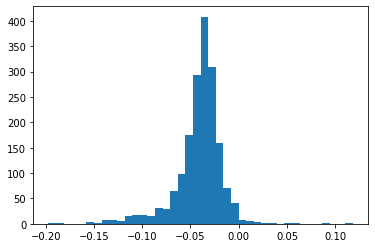

In [18]:
plt.hist(zs_backbone, bins=40)[0][0]

1780.0

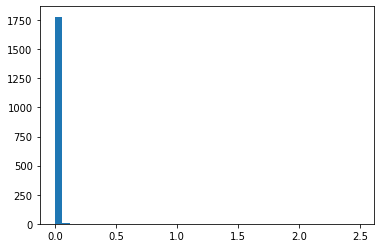

In [19]:
plt.hist(diffs_normalized.flatten(), bins=40)[0][0]

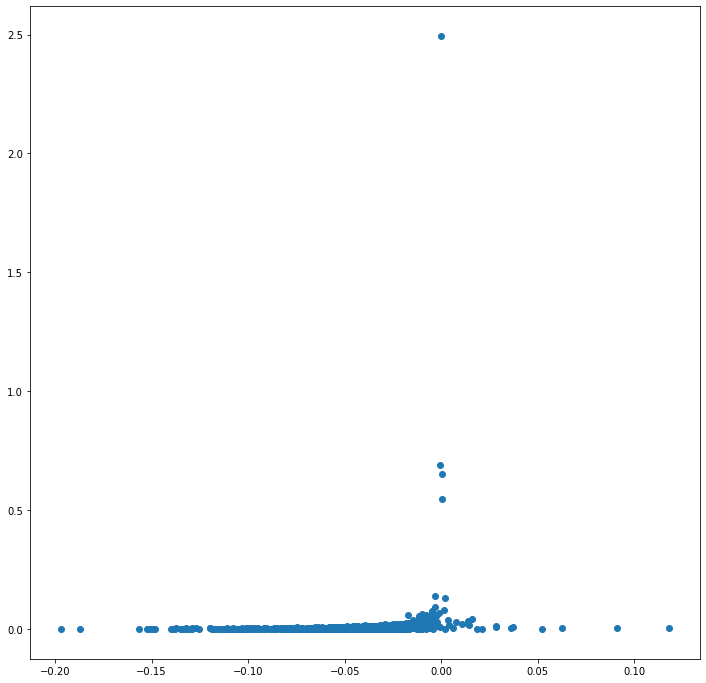

In [20]:
plt.figure(figsize=(12,12))
plt.scatter(x=zs_backbone, y=diffs_normalized)

In [21]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import sys
sys.path.append(f'/home/beans/bespoke')

from models import EffNet
from constants import *
from imports import *
from train_utils import *

import torch
import torch_tensorrt
import timm
import time
import numpy as np
import torch.backends.cudnn as cudnn

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [22]:
stem

'2.10_e4'

In [23]:
stem = "2.10_e4"

m = EffNet().to(device) 
m.load_state_dict(torch.load(f"{SSD_ROOT}/models_deploy/m{stem}.torch"))
m.model_stem = stem
sum([torch.numel(p) for p in m.parameters()]) / 1000

INFO:timm.models.helpers:Loading pretrained weights from url (https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/efficientnet_b4_ra2_320-7eb33cd5.pth)


30484.11

In [24]:
from loaders import *
from rollout import *

run_id = "run_556a"
run = load_object(f"{SSD_ROOT}/runs/{run_id}.pkl")

In [25]:
run.bptt = 4
rollout = Rollout(run, model_stem="stem", m=m, store_imgs=False, trt=False)

0


/home/beans/anaconda3/envs/py38/lib/python3.8/site-packages/torch/utils/checkpoint.py:31: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


400
800
1200
1600
2000
2400
2800
3200
3600
loader is done
Rollout complete!


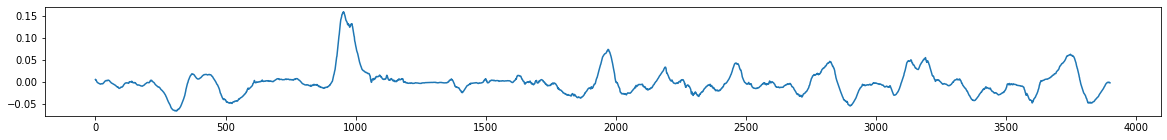

In [26]:
plt.figure(figsize=(20,2))
plt.plot(rollout.additional_results[:,"tire_angle_p"])

In [27]:
m.load_trt_backbone()

In [28]:
run = load_object(f"{SSD_ROOT}/runs/{run_id}.pkl")
run.bptt = 1

In [29]:
TRT_MODEL_PATH

'/media/beans/ssd/models_deploy/backbone_trt.jit.pt'

In [30]:
rollout_trt = Rollout(run, model_stem="stem", m=m, store_imgs=False, trt=True)

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
loader is done
Rollout complete!


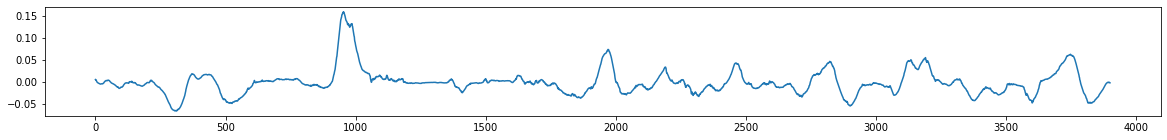

In [31]:
plt.figure(figsize=(20,2))
plt.plot(rollout_trt.additional_results[:,"tire_angle_p"])

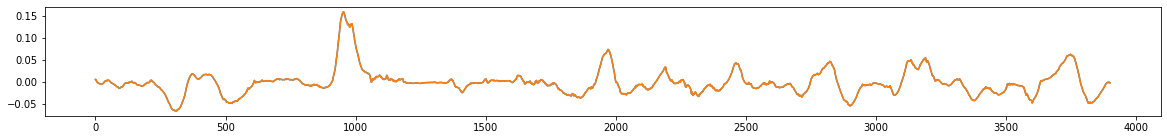

In [37]:
plt.figure(figsize=(20,2))
plt.plot()
plt.plot(rollout_trt.additional_results[:,"tire_angle_p"])

In [45]:
import plotly.graph_objects as go
import plotly.express as px

y = rollout.additional_results[:,"tire_angle_p"]
y1 = rollout_trt.additional_results[:,"tire_angle_p"]

fig = px.scatter(x=list(range(len(y))), y=y, width=1000, height=400)
fig.add_scatter(x=list(range(len(y))), y=y1)

fig.show()

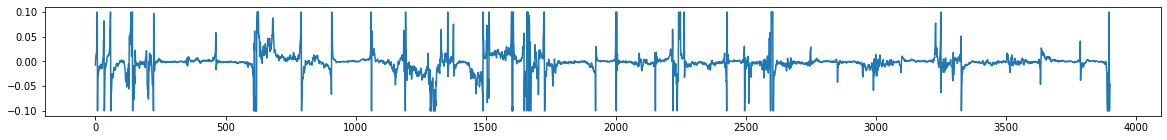

In [36]:
plt.figure(figsize=(20,2))
plt.plot(np.clip(d / rollout.additional_results[:,"tire_angle_p"], -.1, .1))

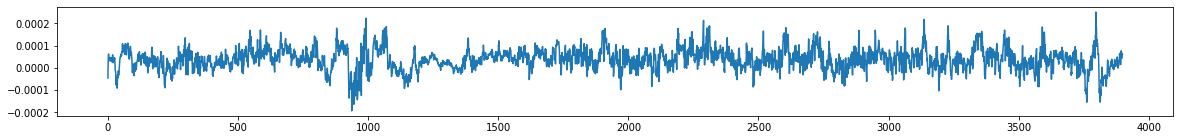

In [33]:
plt.figure(figsize=(20,2))
d = rollout_trt.additional_results[:,"tire_angle_p"] - rollout.additional_results[:,"tire_angle_p"]
plt.plot(d)

In [4]:
import wandb
wandb.init(id='66i4vxlw', project="carla", resume="allow")

wandb: Currently logged in as: rgilman33 (use `wandb login --relogin` to force relogin)
wandb: wandb version 0.13.9 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


In [5]:
%%time
from rollout import RwEvaluator
rw_evaluator = RwEvaluator(m, wandb=wandb, save_rollouts=False, trt=True, run_ids=["run_556a"], bptt=1)

CPU times: user 1.95 ms, sys: 734 µs, total: 2.69 ms
Wall time: 2.31 ms


In [6]:
rw_evaluator.evaluate() #20490

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
loader is done
Rollout complete!
down w rollouts, reporting
run_556a
